In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        raise ValueError("Invalid key.")
        return 'RNN with Fixed LR'
    elif key == 'rnn_fixedlr_alpha':
        return 'RNN with Learned Alpha'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [3]:
def format_dset_name(key):
    if 'discrete_uncorr/pval50/' in key:
        return 'Uncorr.:\n50% Sparse'
    elif 'discrete_uncorr/pval80/' in key:
        return 'Uncorr.:\n80% Sparse'
    elif 'discrete_uncorr/pval95/' in key:
        return 'Uncorr.:\n95% Sparse'
    elif 'discrete_corr/pval50_sigma1.25/' in key:
        return 'Corr.:\n50% Sparse'
    elif 'discrete_corr/pval80_sigma1.25/' in key:
        return 'Corr.:\n80% Sparse'
    elif 'discrete_corr/pval95_sigma1.25/' in key:
        return 'Corr.:\n95% Sparse'
    elif 'discrete_corr/sparse_sigma1.25/' in key:
        return 'Corr.:\nLocalized'
    else:
        return 'Unknown'

In [4]:
hue_order = [
    'Linear',
    'RNN with Learned Alpha',
    'MLP with Replay Buffer',
    #'RNN', 'RNN with Dynamic LR',
    ]

# Plotting each individually

In [5]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    ]

dsets = []
models = []
gammas = []
final_losses = []

for dset_dir in dset_dirs:
    for gamma in os.listdir(f'{root_dir}{dset_dir}'):
        dset_gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
        dset_name = format_dset_name(dset_dir)

        for model in os.listdir(dset_gamma_dir):
            model_dir = dset_gamma_dir + model + '/'
            try:
                model_name = format_model_name(model)
            except:
                continue # Not a directory we care about
            for _iter in os.listdir(model_dir):
                iter_dir = model_dir + _iter + '/'
                for file in os.listdir(iter_dir):
                    if 'tfevents' not in file: continue
                    tfevents_file = iter_dir + '/' + file
                    event_acc = EventAccumulator(tfevents_file)
                    event_acc.Reload()
                    scalar_events = event_acc.Scalars('loss_train')
                    values = np.array([event.value for event in scalar_events])
                    steps = np.array([event.step for event in scalar_events])

                    dsets.append(dset_name)
                    models.append(model_name)
                    gammas.append(gamma)
                    final_losses.append(values[-1])
                    break

dsets = np.array(dsets)
models = np.array(models)
gammas = np.array(gammas)
final_losses = np.array(final_losses)

In [6]:
df = pd.DataFrame({
    'Dataset': dsets,
    'Model': models,
    'Gammas': gammas,
    'Final Loss': final_losses
    })

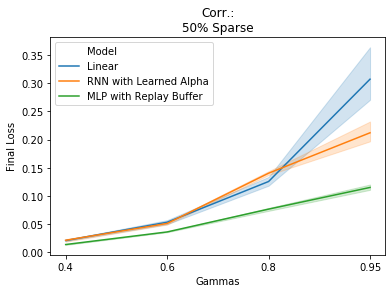

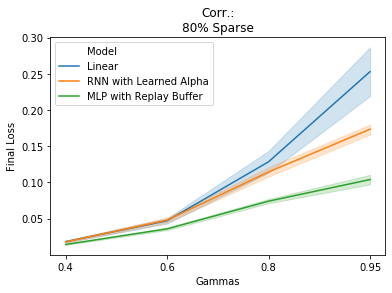

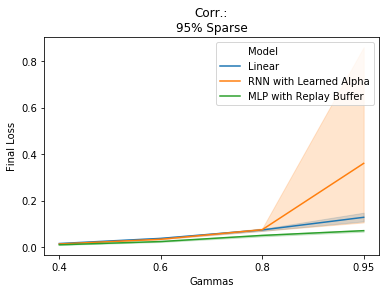

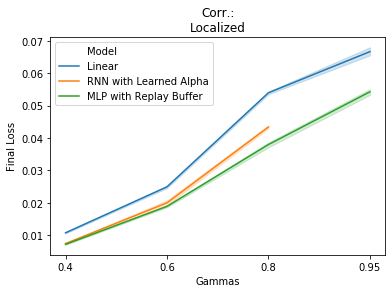

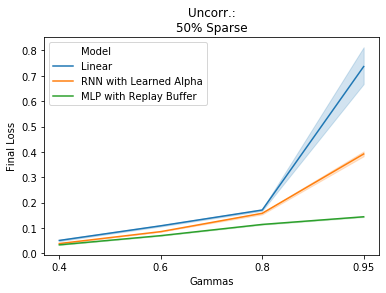

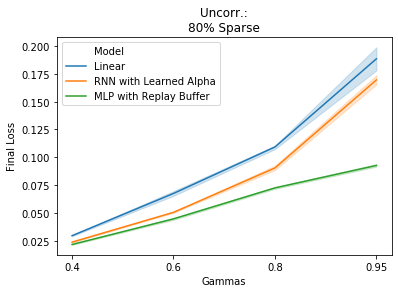

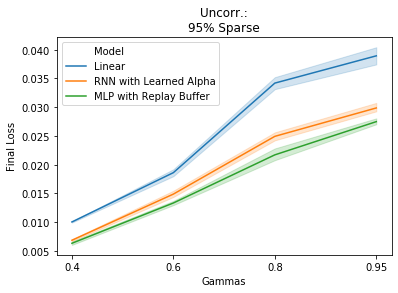

In [7]:
for dset in np.unique(dsets):
    fig, ax = plt.subplots()
    sns.lineplot(
        x='Gammas', y='Final Loss',
        hue='Model', hue_order=hue_order,
        data=df[df['Dataset']==dset]
        )
    plt.title(dset)
    plt.show()

# Combined plot

In [16]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    ]

dsets = []
models = []
gammas = []
loss_folds = []

gammas_list = [0.4, 0.6, 0.8, 0.95]

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    for model in ['rnn_fixedlr_alpha', 'linear', 'mlp']:
        gamma_losses = [[] for _ in gammas_list]
        for idx, gamma in enumerate(gammas_list):
            model_name = format_model_name(model)
            model_dir = f'{root_dir}{dset_dir}{gamma}/{model}/'
            for _iter in os.listdir(model_dir):
                iter_dir = model_dir + _iter + '/'
                for file in os.listdir(iter_dir):
                    if 'tfevents' not in file: continue
                    tfevents_file = iter_dir + '/' + file
                    event_acc = EventAccumulator(tfevents_file)
                    event_acc.Reload()
                    scalar_events = event_acc.Scalars('loss_train')
                    values = np.array([event.value for event in scalar_events])
                    steps = np.array([event.step for event in scalar_events])
                    gamma_losses[idx].append(values[-1])
                    break
        gamma_losses = np.array([np.mean(l) for l in gamma_losses])
        gamma_losses = gamma_losses/gamma_losses[0]
        for gamma, loss_fold in zip(gammas_list, gamma_losses):
            dsets.append(dset_name)
            models.append(model_name)
            gammas.append(gamma)
            loss_folds.append(loss_fold)

dsets = np.array(dsets)
models = np.array(models)
gammas = np.array(gammas)
loss_folds = np.array(loss_folds)

In [25]:
df = pd.DataFrame({
    'Dataset': dsets,
    'Model': models,
    'Gamma': gammas,
    'Fold Increase in Loss': loss_folds
    })

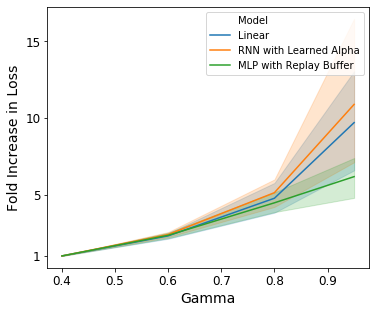

In [30]:
fig, ax = plt.subplots(figsize=(6.4*0.9, 4.8))
sns.lineplot(
    x='Gamma', y='Fold Increase in Loss',
    hue='Model', hue_order=hue_order,
    data=df
    )
plt.xlabel('Gamma', fontsize=14)
plt.ylabel('Fold Increase in Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([1, 5, 10, 15], fontsize=12)
plt.show()